In [1]:
import yfinance
import types
import pkg_resources
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))
spy = yfinance.Ticker('spy')
df = spy.history(period='1y')
df.tail()


yfinance==0.1.72
seaborn==0.11.2
pandas==1.3.4
numpy==1.20.3
matplotlib==3.4.3


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-29,381.230011,382.269989,378.420013,380.339996,65676000,0.0,0
2022-06-30,376.239990,380.660004,372.559998,377.250000,112508300,0.0,0
2022-07-01,376.559998,381.700012,373.799988,381.239990,74792100,0.0,0
2022-07-05,375.880005,381.980011,372.899994,381.959991,81438000,0.0,0
2022-07-06,382.109985,385.420013,379.600006,385.290009,53774816,0.0,0


In [2]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights


In [3]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d: t + 1] if d >= 0 else - \
            d * [self.trend[0]] + self.trend[0: t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' %
                      (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


In [4]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size=window_size, layer_size=500, output_size=3)
agent = Agent(model=model,
              window_size=window_size,
              trend=close,
              skip=skip,
              initial_money=initial_money)
agent.fit(iterations=500, checkpoint=10)


iter 10. reward: 3.157772
iter 20. reward: 3.286967
iter 30. reward: 4.899430
iter 40. reward: 5.154174
iter 50. reward: 5.877070
iter 60. reward: 6.395267
iter 70. reward: 6.644884
iter 80. reward: 6.805510
iter 90. reward: 5.646996
iter 100. reward: 7.173546
iter 110. reward: 5.575527
iter 120. reward: 6.054002
iter 130. reward: 6.424522
iter 140. reward: 6.920061
iter 150. reward: 6.797918
iter 160. reward: 6.777851
iter 170. reward: 8.032087
iter 180. reward: 6.953348
iter 190. reward: 8.364265
iter 200. reward: 8.546196
iter 210. reward: 8.275290
iter 220. reward: 7.260067
iter 230. reward: 8.572715
iter 240. reward: 7.756056
iter 250. reward: 8.911190
iter 260. reward: 9.288819
iter 270. reward: 8.953599
iter 280. reward: 8.667679
iter 290. reward: 9.104701
iter 300. reward: 9.192589
iter 310. reward: 9.353718
iter 320. reward: 9.835987
iter 330. reward: 9.839359
iter 340. reward: 10.227198
iter 350. reward: 10.403449
iter 360. reward: 10.183505
iter 370. reward: 10.029888
iter 3

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy()


day 7: buy 1 unit at price 428.655396, total balance 9571.344604
day 8: buy 1 unit at price 425.293182, total balance 9146.051422
day 9: buy 1 unit at price 419.012482, total balance 8727.038940
day 10: buy 1 unit at price 425.017090, total balance 8302.021851
day 13, sell 1 unit at price 433.772644, investment 1.193791 %, total balance 8735.794495,
day 14: buy 1 unit at price 434.837494, total balance 8300.957001
day 16, sell 1 unit at price 432.678162, investment 1.736444 %, total balance 8733.635162,
day 19, sell 1 unit at price 431.455566, investment 2.969621 %, total balance 9165.090729,
day 20: buy 1 unit at price 434.965668, total balance 8730.125061
day 23: buy 1 unit at price 436.286865, total balance 8293.838196
day 24: buy 1 unit at price 435.931946, total balance 7857.906250
day 26: buy 1 unit at price 437.558807, total balance 7420.347443
day 27, sell 1 unit at price 438.870148, investment 3.259412 %, total balance 7859.217590,
day 30: buy 1 unit at price 437.815125, total

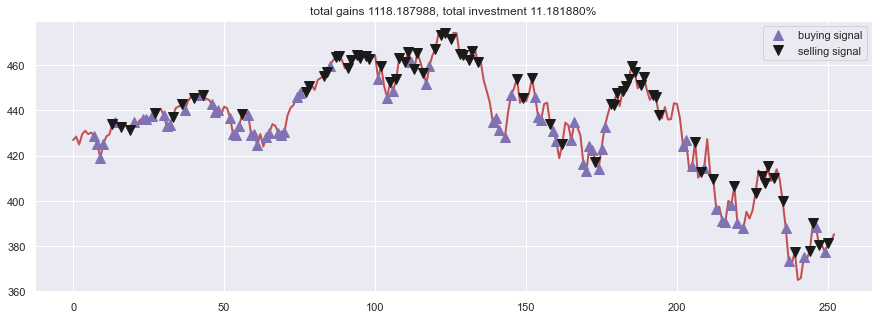

In [8]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()